In [22]:
import cv2
import os
import json
import matplotlib.pyplot as plt
# 设置matplotlib中文支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号


# 1. 读原图，获取宽高
img_path = 'C:\\workspace\\mys-ocr\\828\\E2\\2024_08_29T19_07_25-top-329-marked.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
h_img, w_img = img.shape[:2]

In [23]:
# 交互式图像裁剪函数, 用于获得坐标和裁剪图像
def interactive_crop_image(image_array, window_name='Crop', output_filename='template.jpg', save_image=False,
                           scale_factor=1.0):
    """
    交互式图像裁剪函数

    参数:

    - image_array: cv2.imread读取后的图片对象
    - window_name: 选择窗口名称
    - output_filename: 输出文件名
    - save_image: 是否保存裁剪后的图片，默认False
    - scale_factor: 显示时的缩放倍数，默认2.0倍

    返回:
    - tuple: 裁剪区域坐标 (x, y, w, h)，如果用户取消则返回 None
    """
    if len(image_array.shape) == 3:
        img = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    else:
        img = image_array.copy()

    if img is None:
        print("无法加载图像")
        return None

    # 获取原始图像尺寸
    original_height, original_width = img.shape[:2]

    # 放大图像用于显示
    display_img = cv2.resize(img, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)

    roi = cv2.selectROI(window_name, display_img, showCrosshair=False)  # 返回 (x,y,w,h)

    if roi != (0, 0, 0, 0):
        # 将显示图像的坐标转换回原始图像坐标
        x, y, w, h = [int(v / scale_factor) for v in roi]

        # 确保坐标不超出原始图像边界
        x = max(0, min(x, original_width))
        y = max(0, min(y, original_height))
        w = max(1, min(w, original_width - x))
        h = max(1, min(h, original_height - y))

        print(f"原始坐标: {x}, {y}, {w}, {h}")
        print(f"显示缩放倍数: {scale_factor}x")

        if save_image:
            cropped = img[y:y + h, x:x + w]
            cv2.imwrite(output_filename, cropped)
            print(f"图片已保存为: {output_filename}")
        cv2.destroyAllWindows()
        return x, y, w, h
    else:
        cv2.destroyAllWindows()
        return None

# 新增：多框选文字区域，并转换为相对模板框的偏移量
# 新增支持：
# - focus_rect: 仅在模板附近显示并进行缩放，适配超大图；
# - 自动缩放：当 scale_factor 为 None 时，按目标显示尺寸自动计算缩放比例；
# - 窗口标题使用 ASCII，避免中文乱码；

def select_text_regions(
        image_array,
        scale_factor: float | None = 1.0,
        window_name: str = 'Select Text Regions',
        focus_rect: tuple | None = None,
        target_display_size: tuple = (1200, 900),
        rect_color: tuple = (0, 255, 0),
        thickness: int = 2
    ):
    """
    自定义多框选择（支持颜色可控的矩形显示），替代 cv2.selectROIs。

    参数：
    - image_array: 输入图像（可灰度或BGR）
    - scale_factor: 显示缩放倍数；为 None 时按 target_display_size 自动计算
    - window_name: 窗口名称（请使用 ASCII 以避免 OpenCV 标题乱码）
    - focus_rect: (x0, y0, x1, y1)，若提供则仅显示该区域的放大图用于框选
    - target_display_size: (max_w, max_h)，用于自动缩放的目标显示尺寸
    - rect_color: 选择框颜色（BGR），例如 (0,255,0) 为绿色
    - thickness: 线宽

    返回：list[(x, y, w, h)]，坐标为原图坐标，按 y 从小到大排序。
    """
    # 统一为灰度
    if len(image_array.shape) == 3:
        gray = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    else:
        gray = image_array.copy()

    if gray is None:
        print("无法加载图像")
        return []

    H, W = gray.shape[:2]

    # 计算裁剪区域与偏移
    if focus_rect is not None:
        x0, y0, x1, y1 = focus_rect
        x0 = max(0, min(int(x0), W - 1))
        y0 = max(0, min(int(y0), H - 1))
        x1 = max(0, min(int(x1), W))
        y1 = max(0, min(int(y1), H))
        if x1 <= x0: x1 = min(W, x0 + 1)
        if y1 <= y0: y1 = min(H, y0 + 1)
        crop = gray[y0:y1, x0:x1]
        offx, offy = x0, y0
    else:
        crop = gray
        offx, offy = 0, 0

    ch, cw = crop.shape[:2]

    # 自动缩放计算
    if scale_factor is None:
        max_w, max_h = target_display_size
        # 让裁剪区尽量充满目标窗口
        scale_w = max_w / max(1, cw)
        scale_h = max_h / max(1, ch)
        scale_factor = min(scale_w, scale_h)
        # 限制缩放范围，避免过度缩放
        scale_factor = max(0.2, min(8.0, scale_factor))

    # 生成用于显示的图像（彩色，用于绘制彩色矩形）
    disp_gray = cv2.resize(crop, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
    if len(disp_gray.shape) == 2:
        display_base = cv2.cvtColor(disp_gray, cv2.COLOR_GRAY2BGR)
    else:
        display_base = disp_gray.copy()

    # 注意：OpenCV 标题中文易乱码，这里建议使用英文 ASCII 标题
    safe_title = window_name.encode('ascii', errors='ignore').decode('ascii') or 'Select Regions'
    cv2.namedWindow(safe_title, cv2.WINDOW_NORMAL)

    # 交互状态
    drawing = False
    start_pt = (0, 0)
    cur_pt = (0, 0)
    rects_disp = []  # 在显示坐标系(缩放后)下的矩形列表 (x,y,w,h)

    def on_mouse(event, x, y, flags, param):
        nonlocal drawing, start_pt, cur_pt, rects_disp
        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            start_pt = (x, y)
            cur_pt = (x, y)
        elif event == cv2.EVENT_MOUSEMOVE and drawing:
            cur_pt = (x, y)
        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
            cur_pt = (x, y)
            x0, y0 = start_pt
            x1, y1 = cur_pt
            if x1 < x0: x0, x1 = x1, x0
            if y1 < y0: y0, y1 = y1, y0
            w = max(1, x1 - x0)
            h = max(1, y1 - y0)
            rects_disp.append((x0, y0, w, h))

    cv2.setMouseCallback(safe_title, on_mouse)

    print("提示：");
    print("- 鼠标左键拖动绘制一个矩形框；")
    print("- 按 Z 撤销上一个矩形；Enter 完成；Esc 取消。")

    while True:
        vis = display_base.copy()
        # 画已有矩形
        for (x, y, w, h) in rects_disp:
            cv2.rectangle(vis, (x, y), (x + w, y + h), rect_color, thickness)
        # 画当前正在绘制的矩形
        if drawing:
            x0, y0 = start_pt
            x1, y1 = cur_pt
            x_min, y_min = min(x0, x1), min(y0, y1)
            x_max, y_max = max(x0, x1), max(y0, y1)
            cv2.rectangle(vis, (x_min, y_min), (x_max, y_max), rect_color, thickness)
        cv2.imshow(safe_title, vis)
        k = cv2.waitKey(20) & 0xFF
        if k == 27:  # Esc 取消
            rects_disp = []
            break
        elif k == 13:  # Enter 完成
            break
        elif k in (ord('z'), ord('Z')):
            if rects_disp:
                rects_disp.pop()

    cv2.destroyAllWindows()

    # 将显示坐标矩形 -> 裁剪区坐标 -> 原图坐标
    rects = []
    for (x, y, w, h) in rects_disp:
        if w <= 0 or h <= 0:
            continue
        x0r = int(x / scale_factor) + offx
        y0r = int(y / scale_factor) + offy
        w0r = int(w / scale_factor)
        h0r = int(h / scale_factor)
        # 边界校正
        x0r = max(0, min(x0r, W))
        y0r = max(0, min(y0r, H))
        w0r = max(1, min(w0r, W - x0r))
        h0r = max(1, min(h0r, H - y0r))
        rects.append((x0r, y0r, w0r, h0r))

    # 按顶部 y 排序（从上到下）
    rects.sort(key=lambda r: r[1])
    return rects


def rois_to_offsets(rois, template_top_left, template_bottom_right):
    """
    将 ROI 列表转换为与模板矩形相对的偏移字典列表。
    每个偏移字典格式：{'x0':..., 'y0':..., 'x1':..., 'y1':...}
    其中 x0/y0 是 ROI 左上角相对模板左上角的偏移，x1/y1 是 ROI 右下角相对模板右下角的偏移。
    """
    tx, ty = template_top_left
    bx, by = template_bottom_right
    offsets = []
    for (x, y, w, h) in rois:
        rx = x + w
        ry = y + h
        offsets.append({
            'x0': x - tx,
            'y0': y - ty,
            'x1': rx - bx,
            'y1': ry - by,
        })
    return offsets


def tweak_offset(offset_dict: dict, key: str, delta: int):
    """
    简单的数值调整工具：对指定 offset 字典的某个键进行加减，并返回调整后的新字典。
    例如：tweak_offset(first_line_offset, 'x0', +2)
    """
    if key not in offset_dict:
        raise KeyError(f"键 {key} 不存在，可用键为 x0/y0/x1/y1")
    new_d = dict(offset_dict)
    new_d[key] = int(new_d[key]) + int(delta)
    return new_d

# # 使用示例，设置缩放倍数为3倍以便更好地进行裁剪操作
# image_obj = cv2.imread('291.jpg')
coordinates = interactive_crop_image(img, save_image=True, scale_factor=1)
if coordinates:
    print(f"裁剪成功，坐标: {coordinates}")
else:
    print("用户取消了裁剪操作")


原始坐标: 1373, 662, 234, 96
显示缩放倍数: 1x
图片已保存为: template.jpg
裁剪成功，坐标: (1373, 662, 234, 96)


找到匹配! 置信度: 0.9935
位置: (1373, 662)


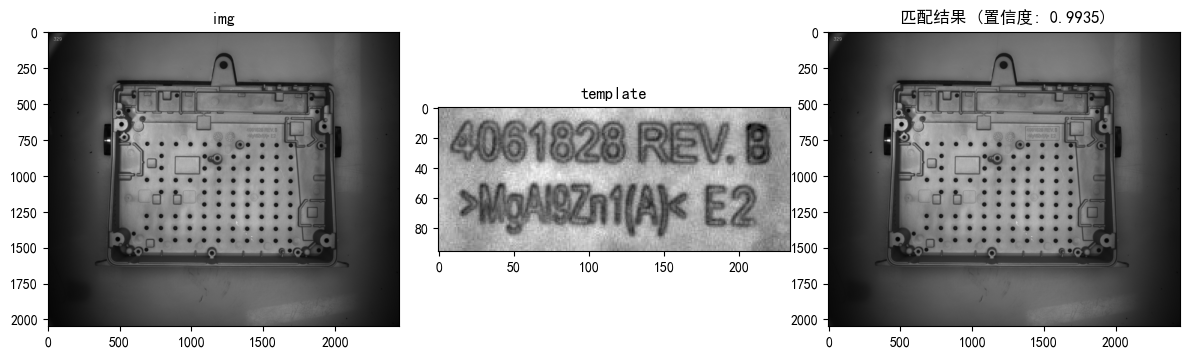

In [24]:
# 加载模板图像
template = cv2.imread("template.jpg", cv2.IMREAD_GRAYSCALE)
found = False  # 标记是否找到匹配点
best_match = None  # 存储最佳匹配信息
template_height, template_width = template.shape
# 执行模板匹配
result = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

# 设置匹配阈值
threshold = 0.8
if max_val >= threshold:
    found = True
    best_match = {
        'location': max_loc,
        'confidence': max_val,
        'top_left': max_loc,
        'bottom_right': (max_loc[0] + template_width, max_loc[1] + template_height)
    }
    print(f"找到匹配! 置信度: {max_val:.4f}")
    print(f"位置: {max_loc}")
else:
    print(f"未找到匹配, 最高置信度: {max_val:.4f} (阈值: {threshold})")

# 可视化结果
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('img')

plt.subplot(1, 3, 2)
plt.imshow(template, cmap='gray')
plt.title('template')
plt.tight_layout()

# 在原图上标记匹配位置
match_img = img.copy()
top_left = best_match['top_left']
bottom_right = best_match['bottom_right']
cv2.rectangle(match_img, top_left, bottom_right, 0, 1)

plt.subplot(1, 3, 3)
plt.imshow(match_img, cmap='gray')
plt.title(f'匹配结果 (置信度: {max_val:.4f})')
plt.show()

提示：
- 鼠标左键拖动绘制一个矩形框；
- 按 Z 撤销上一个矩形；Enter 完成；Esc 取消。
手动框选得到的偏移，共 2 个：
first_line = {'x0': 5, 'y0': 0, 'x1': -7, 'y1': -50}
second_line = {'x0': 7, 'y0': 44, 'x1': -12, 'y1': -3}
已写入偏移配置到: offsets_config.json（格式适配 send2yolo.py）


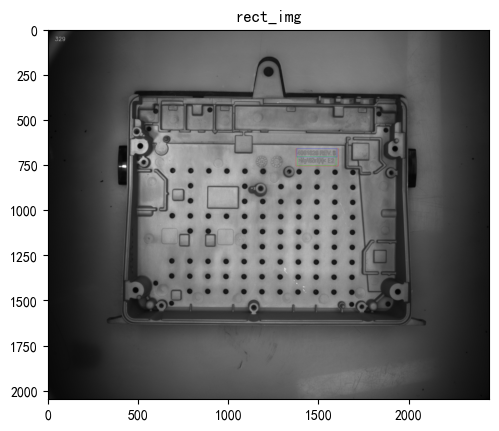

In [25]:
rect_img = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
cv2.rectangle(rect_img, top_left, bottom_right, (0, 0, 255), 1)

# 手动框选开关：True 使用手动框选得到偏移；False 使用原有固定偏移
USE_MANUAL_SELECTION = True
MANUAL_SCALE = 3.0  # 框选时的显示缩放倍数；>0 使用该倍数，<=0 或 None 则启用自动缩放

# 后备（默认）偏移配置：直接在 Notebook 内定义（支持任意数量，默认提供三条）
_default_offsets_list = [
    {'name': 'first_line',  'x0': 43, 'y0': 90, 'x1': 5,   'y1': 50},
    {'name': 'second_line', 'x0': 25, 'y0': 77, 'x1': -10, 'y1': 67},
    {'name': 'third_line',  'x0': 7,  'y0': 80, 'x1': -30, 'y1': 67},
]

if USE_MANUAL_SELECTION:
    # 以模板中心为基准，构造聚焦区域（在模板四周添加边距）
    tlx, tly = top_left
    brx, bry = bottom_right
    tmpl_w = brx - tlx
    tmpl_h = bry - tly
    # 边距：模板尺寸的 1.5 倍，可按需调整
    pad_x = int(max(20, 3 * tmpl_w))
    pad_y = int(max(20, 3 * tmpl_h))
    fx0 = max(0, tlx - pad_x)
    fy0 = max(0, tly - pad_y)
    fx1 = min(img.shape[1], brx + pad_x)
    fy1 = min(img.shape[0], bry + pad_y)

    # 使用英文窗口标题避免乱码，且根据 focus_rect 自动缩放
    # 根据 MANUAL_SCALE 决定缩放策略：>0 使用手动缩放；<=0 或 None 使用自动缩放
    _scale_arg = MANUAL_SCALE if (MANUAL_SCALE is not None and MANUAL_SCALE > 0) else None
    rois = select_text_regions(
        img,
        scale_factor=_scale_arg,  # 手动/自动
        window_name='Select text regions (top to bottom)',
        focus_rect=(fx0, fy0, fx1, fy1),
        target_display_size=(1200, 900),
        rect_color=(0, 0, 255),  # 手动框选颜色：红色
        thickness=2
    )
    if len(rois) >= 1:
        offsets = rois_to_offsets(rois, top_left, bottom_right)
        offsets_list = []
        for i, off in enumerate(offsets):
            # 命名策略：前3个按 first/second/third_line 命名，其余使用 line_XX
            if i == 0:
                name_i = 'first_line'
            elif i == 1:
                name_i = 'second_line'
            elif i == 2:
                name_i = 'third_line'
            else:
                name_i = f'line_{i+1:02d}'
            offsets_list.append({
                'name': name_i,
                'x0': int(off['x0']),
                'y0': int(off['y0']),
                'x1': int(off['x1']),
                'y1': int(off['y1']),
            })
        print(f"手动框选得到的偏移，共 {len(offsets_list)} 个：")
        for it in offsets_list:
            print(it['name'], '=', {k: it[k] for k in ['x0','y0','x1','y1']})
        # 将偏移写入外部 JSON 配置文件（供 send2yolo.py 读取）
        offsets_config = {it['name']: {'x0': it['x0'], 'y0': it['y0'], 'x1': it['x1'], 'y1': it['y1']} for it in offsets_list}
        config_path = 'offsets_config.json'
        try:
            with open(config_path, 'w', encoding='utf-8') as f:
                json.dump(offsets_config, f, ensure_ascii=False, indent=2)
            print(f"已写入偏移配置到: {config_path}（格式适配 send2yolo.py）")
        except Exception as e:
            print(f"写入偏移配置失败: {e}")
    else:
        print('提示：未成功选择到任何区域，改用默认偏移。')
        offsets_list = list(_default_offsets_list)
else:
    # 使用默认偏移
    offsets_list = list(_default_offsets_list)

# 示例：保留并演示“修改某个数值”的能力（按需启用）
ENABLE_TWEAK_EXAMPLE = False
if ENABLE_TWEAK_EXAMPLE and offsets_list:
    # 例如将第一条 x0 增加 2 个像素
    offsets_list[0] = tweak_offset(offsets_list[0], 'x0', +2)
    print('调整后的第一条偏移 =', offsets_list[0])

# 依据 offsets_list 计算、绘制所有矩形
rects_px = []  # [(name, (x0,y0), (x1,y1))]
for it in offsets_list:
    name = it.get('name', '')
    tl = [top_left[0] + int(it['x0']), top_left[1] + int(it['y0'])]
    br = [bottom_right[0] + int(it['x1']), bottom_right[1] + int(it['y1'])]
    rects_px.append((name, tuple(tl), tuple(br)))

# 依序着色绘制
colors = [(255,0,0),(0,255,0),(255,255,0),(255,0,255),(0,255,255),(0,128,255),(128,0,255)]
for idx, (_, tl, br) in enumerate(rects_px):
    color = colors[idx % len(colors)]
    cv2.rectangle(rect_img, tl, br, color, 1)

plt.title('rect_img')
plt.imshow(cv2.cvtColor(rect_img, cv2.COLOR_BGR2RGB))
plt.show()


In [26]:
# 依据 rects_px 批量裁剪、旋转并保存图片
cropped_infos = []  # [(name, crop_img)]
for i, (name, tl, br) in enumerate(rects_px):
    x0, y0 = tl
    x1, y1 = br
    # 边界校正
    x0 = max(0, min(x0, w_img-1))
    y0 = max(0, min(y0, h_img-1))
    x1 = max(0, min(x1, w_img))
    y1 = max(0, min(y1, h_img))
    if x1 <= x0 or y1 <= y0:
        continue
    crop = img[y0:y1, x0:x1]
    # 与原逻辑一致：旋转180度
    crop = cv2.rotate(crop, cv2.ROTATE_180)
    out_name = name if name else f'line_{i+1:02d}'
    out_file = f'{out_name}.jpg'
    cv2.imwrite(out_file, crop)
    print(f"{out_name} 已保存为: {out_file}, 尺寸: {crop.shape}")
    cropped_infos.append((out_name, crop))


first_line 已保存为: first_line.jpg, 尺寸: (46, 222)
second_line 已保存为: second_line.jpg, 尺寸: (49, 215)


In [27]:
# 2. 基于模板匹配结果动态计算边界框（与 rects_px 对应）
boxes = []
for name, tl, br in rects_px:
    x = tl[0]
    y = tl[1]
    w = br[0] - tl[0]
    h = br[1] - tl[1]
    boxes.append({
        'name': name,
        'class': 0,
        'x': x, 'y': y, 'w': w, 'h': h,
    })

print("动态计算的边界框:")
for i, box in enumerate(boxes, 1):
    tag = box.get('name') or f'line_{i:02d}'
    print(f"  {tag}: x={box['x']}, y={box['y']}, w={box['w']}, h={box['h']}")

# 3. 转换为 YOLO 格式
labels = []
for box in boxes:
    x, y, w, h = box['x'], box['y'], box['w'], box['h']
    # 确保边界框在图片范围内
    x = max(0, min(x, w_img))
    y = max(0, min(y, h_img))
    w = max(1, min(w, w_img - x))
    h = max(1, min(h, h_img - y))
    xc = x + w / 2
    yc = y + h / 2
    # 归一化
    xc_norm = xc / w_img
    yc_norm = yc / h_img
    w_norm  = w  / w_img
    h_norm  = h  / h_img
    labels.append(f"{box['class']} {xc_norm:.6f} {yc_norm:.6f} {w_norm:.6f} {h_norm:.6f}")

print("\nYOLO格式标注:")
for i, label in enumerate(labels, 1):
    print(f"  line_{i:02d}: {label}")

动态计算的边界框:
  first_line: x=1378, y=662, w=222, h=46
  second_line: x=1380, y=706, w=215, h=49

YOLO格式标注:
  line_01: 0 0.608252 0.334473 0.090686 0.022461
  line_02: 0 0.607639 0.356689 0.087827 0.023926


In [28]:
# 4. 保存为 txt
txt_path = os.path.splitext(img_path)[0] + '.txt'
with open(txt_path, 'w') as f:
    f.write('\n'.join(labels))

print("已生成 YOLO 标注文件：", txt_path)

已生成 YOLO 标注文件： C:\workspace\mys-ocr\828\E2\2024_08_29T19_07_25-top-329-marked.txt
